<a href="https://colab.research.google.com/github/ReynaldoHdz/Cosechadores-Multiagentes/blob/main/REVISION_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install agentpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.9 MB/s eta 0:00:00


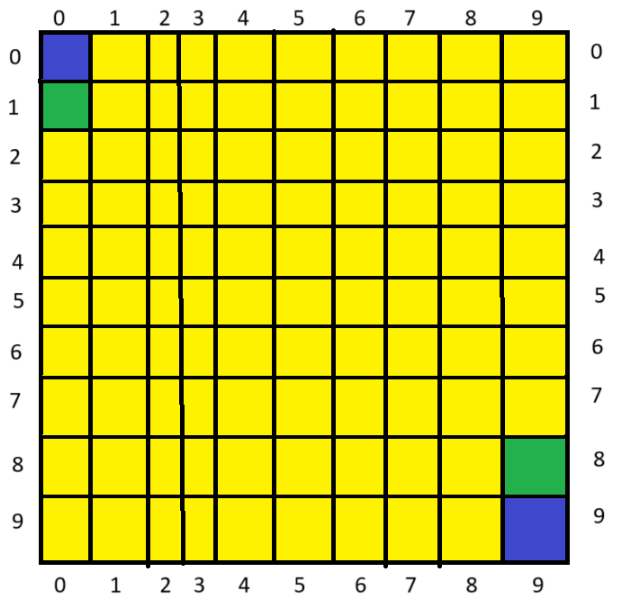

In [ ]:
# Model design
import agentpy as ap
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd

from google.colab import files

In [ ]:
# Q-learning algorithm parameters
alpha = 0.75  # Learning rate
gamma = 0.4  # Discount factor
epsilon = 0.99  # Probability of exploration

size = 7

Q_table_harvester = np.zeros((size, size, 4))

In [ ]:
movementsH1 = []
movementsT1 = []
movementsH2 = []
movementsT2 = []

In [ ]:
class HarvesterAgent(ap.Agent):

  def setup(self):

    # Initialize Q-table, states, actions, etc.

    self.Q = Q_table_harvester # 4 possible actions (up, down, left, right)
    self.state = (0,0)
    self.action = 0
    self.last_state = (0,0)
    self.crops_harvested = 0
    self.max_capacity = 10
    self.unloading_harvest = False

    self.decision = ""
    self.visitedTiles = []
    self.track = 0#2

  def choose_action(self, state):

    # Choose the next action based on exploration-exploitation trade-off (e-greedy)

    if np.random.rand() < epsilon:
      self.action = np.random.randint(4)  # Random exploration
    else:
      self.action = np.argmax(self.Q[state]) # Gets the index of the highest value

  def take_action(self):

    # Move the harvester based on the selected action (assuming 4 possible movements)

    movements = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right

    movement = movements[self.action]

    new_state = tuple(np.add(self.state, movement))

    # Convert tractor positions to a list of tuples for comparison
    #harvester_positions = [tuple(agent.state) for agent in self.model.harvesters if agent != self]
    #tractor_positions = [tuple(agent.state) for agent in self.model.tractors if agent != self]
    harvester_positions = []
    harvester_positions_debug = []
    tractor_positions = []
    for harvester in self.model.harvesters:
      harvester_positions_debug.append(tuple(self.model.field.positions[harvester]))
      if harvester != self:
        harvester_positions.append(tuple(self.model.field.positions[harvester]))
    for tractor in self.model.tractors:
      tractor_positions.append(tuple(self.model.field.positions[tractor]))

    #print("\nH pos: ",harvester_positions_debug)
    #print("T pos: ",tractor_positions)
    # Update state (position)
    if movement == (-1, 0):
      self.decision = "up"
    if movement == (1, 0):
      self.decision = "down"
    if movement == (0, -1):
      self.decision = "left"
    if movement == (0, 1):
      self.decision = "right"

    if (
        0 <= new_state[0] < self.p.size
        and 0 <= new_state[1] < self.p.size
        and new_state not in harvester_positions
        and new_state not in tractor_positions
    ):
        self.last_state = self.state
        self.state = new_state

    else:
      movement = (0,0)

    return movement

  def update_Q_table(self, state, action, reward, next_state):

    # Update Q-values based on the Q-Learning algorithm

    self.Q[state][action] = (1 - alpha) * self.Q[state][action] + alpha * (reward + gamma * np.max(self.Q[next_state]))

    Q_table_harvester = self.Q


class TractorAgent(ap.Agent):

  def setup(self):

    # Initialize Q-table, states, actions, etc.

    self.state = (0,0)
    self.action = 0
    self.last_state = (0,0)
    self.capacity = 0
    self.track = 0#3


class CropAgent(ap.Agent):

  def setup(self):

    self.track = 1

    # Condition 0: Harvested, 1: Not harvested
    self.status = 1



In [ ]:
class HarvestModel(ap.Model):

  def setup(self):

    # Create agents (crops, harvesters, tractors)
    self.crops = ap.AgentList(self, self.p.crops, CropAgent)

    self.tractors = ap.AgentList(self, 2, TractorAgent)

    self.harvesters = ap.AgentList(self, 2, HarvesterAgent)

    self.visited = []

    movementsH1.clear()
    movementsT1.clear()
    movementsH2.clear()
    movementsT2.clear()

    # Create grid (field)
    self.field = ap.Grid(self, [self.p.size]*2, check_border=True, track_empty=True)

    # Add two harvesters and two tractors at opposite corners
    #self.field.add_agents(self.harvesters,[(1,0)])
    #self.field.add_agents(self.harvesters,[(0,0),(self.p.size - 1, self.p.size - 1)])
    self.field.add_agents(self.harvesters,[(1,0),(self.p.size - 2, self.p.size - 1)])

    #self.field.add_agents(self.tractors, [(0,0)])
    self.field.add_agents(self.tractors, [(0,0),(self.p.size - 1, self.p.size - 1)])

    for harvester in self.harvesters:
      harvester.state = self.field.positions[harvester]
      self.visited.append(self.field.positions[harvester])

    for tractor in self.tractors:
      tractor.state = self.field.positions[tractor]

    # Populate the field with crops
    self.field.add_agents(self.crops, random=False, empty=True)

  def step(self):

    i = 0
    for harvester, tractor in zip(self.harvesters, self.tractors):

      if harvester.unloading_harvest == True:
        if harvester.crops_harvested != 0:
          harvester.crops_harvested -= 1
          tractor.capacity += 1
        else:
          harvester.unloading_harvest = False
        continue

      # Store the state before the action
      #harvester.last_state = harvester.state

      # Choose action based on the current state
      harvester.choose_action(self.field.positions[harvester])

      # Take action and move the harvester
      movement = harvester.take_action()
      self.field.move_by(harvester, movement)
      self.visited.append(harvester.state)

      filling = 3
      # Store movement in movements list
      if movement == (-1,0):
        if i == 0:
          movementsH1.append("up")
          for _ in range(filling):
            movementsH1.append("0")
        else:
          movementsH2.append("up")
          for _ in range(filling):
            movementsH2.append("0")
      elif movement == (1,0):
        if i == 0:
          movementsH1.append("down")
          for _ in range(filling):
            movementsH1.append("0")
        else:
          movementsH2.append("down")
          for _ in range(filling):
            movementsH2.append("0")
      elif movement == (0,-1):
        if i == 0:
          movementsH1.append("left")
          for _ in range(filling):
            movementsH1.append("0")
        else:
          movementsH2.append("left")
          for _ in range(filling):
            movementsH2.append("0")
      elif movement == (0,1):
        if i == 0:
          movementsH1.append("right")
          for _ in range(filling):
            movementsH1.append("0")
        else:
          movementsH2.append("right")
          for _ in range(filling):
            movementsH2.append("0")
      else:
        if i == 0:
          movementsH1.append("none")
          for _ in range(filling):
            movementsH1.append("0")
        else:
          movementsH2.append("none")
          for _ in range(filling):
            movementsH2.append("0")

      # Tractor follows harvester
      self.field.move_to(tractor, harvester.last_state)
      tractor.state = self.field.positions[tractor]

      # Calculate reward
      reward = 0
      for crop in self.crops:
        if self.field.positions[crop] == self.field.positions[harvester] and crop.status == 1:
          crop.status = 0
          crop.track = 0
          harvester.crops_harvested += 1
          reward += -1  # Accumulate reward for each harvested crop
        else:
          reward += -3  # Penalty for wasting a step without harvesting anything

        if self.field.positions[crop] == tractor.state and crop.status == 1:
          crop.track = 4

      # Penalty for moving to a tile previously on:
      if harvester.state in self.visited[:-1]:
        reward += -8

      # Update Q-table for the harvester
      harvester.update_Q_table(harvester.last_state, harvester.action, reward, harvester.state)

      if harvester.crops_harvested == harvester.max_capacity:
        harvester.unloading_harvest = True

      i += 1

    # Simulation ends when there are no crops left to harvest
    if len(self.crops.select(self.crops.status == 1)) == 0:

      best_actions = {}  # Store best actions for each state

      # Find best actions for each state based on the maximum Q-value
      for state in self.visited:
        max_action = np.argmax(self.harvesters[0].Q[state])  # Assuming the first harvester for Q-table access
        best_actions[state] = max_action

      # Update Q-table with a high final reward only for the best actions
      for harvester in self.harvesters:
        final_reward = 0.5  # High reward for successful harvesting

        # Update Q-table only for the best action in each state that led to successful harvesting
        harvester.update_Q_table(harvester.last_state, best_actions[harvester.last_state], final_reward, harvester.state)

      self.stop()

  def end(self):

    self.report('harvested crops', len(self.crops.select(self.crops.status == 0)))
    #movementsT1.append('up')
    movementsT1.extend(movementsH1)
    movementsT1.pop()
    movementsT1.append('end')
    #movementsT2.append('up')
    movementsT2.extend(movementsH2)
    movementsT2.pop()
    movementsT2.append('end')


In [ ]:
parameters = {
  'crops': 45,
  'size': 7, # Height and length of the field
  'steps': 300,
}

In [ ]:
model = HarvestModel(parameters)
results = model.run()

#print(results.arrange_reporters())
#print(Q_table_harvester)

Completed: 159 steps
Run time: 0:00:00.097207
Simulation finished


In [ ]:
print("H1: ", movementsH1)
print("T1: ", movementsT1)
#print("H2: ", movementsH2)
#print("T2: ", movementsT2)
#print("H1: ", len(movementsH1))
#print("T1: ", len(movementsT1))
#print("H2: ", len(movementsH2))
#print("T2: ", len(movementsT2))

H1:  ['none', '0', '0', '0', 'right', '0', '0', '0', 'right', '0', '0', '0', 'none', '0', '0', '0', 'right', '0', '0', '0', 'down', '0', '0', '0', 'down', '0', '0', '0', 'right', '0', '0', '0', 'up', '0', '0', '0', 'up', '0', '0', '0', 'right', '0', '0', '0', 'down', '0', '0', '0', 'right', '0', '0', '0', 'right', '0', '0', '0', 'right', '0', '0', '0', 'up', '0', '0', '0', 'none', '0', '0', '0', 'none', '0', '0', '0', 'none', '0', '0', '0', 'none', '0', '0', '0', 'up', '0', '0', '0', 'none', '0', '0', '0', 'none', '0', '0', '0', 'none', '0', '0', '0', 'left', '0', '0', '0', 'left', '0', '0', '0', 'up', '0', '0', '0', 'up', '0', '0', '0', 'none', '0', '0', '0', 'none', '0', '0', '0', 'left', '0', '0', '0', 'left', '0', '0', '0', 'down', '0', '0', '0', 'none', '0', '0', '0', 'left', '0', '0', '0', 'up', '0', '0', '0', 'none', '0', '0', '0', 'none', '0', '0', '0', 'right', '0', '0', '0', 'down', '0', '0', '0', 'down', '0', '0', '0', 'left', '0', '0', '0', 'down', '0', '0', '0', 'down', '0

In [ ]:
# Writing list contents to separate text files
with open('movementsH1.txt', 'w') as file_H1:
    for item in movementsH1:
        file_H1.write('%s\n' % item)

with open('movementsT1.txt', 'w') as file_T1:
    for item in movementsT1:
        file_T1.write('%s\n' % item)

with open('movementsH2.txt', 'w') as file_H2:
    for item in movementsH2:
        file_H2.write('%s\n' % item)

with open('movementsT2.txt', 'w') as file_T2:
    for item in movementsT2:
        file_T2.write('%s\n' % item)

# Downloading the text files
files.download('movementsH1.txt')
files.download('movementsT1.txt')
files.download('movementsH2.txt')
files.download('movementsT2.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
exp = ap.Experiment(HarvestModel, parameters, iterations=300)
results = exp.run()
print(results.arrange(reporters='harvested crops'))

Scheduled runs: 300
Completed: 132, estimated time remaining: 0:00:28

KeyboardInterrupt: ignored

In [ ]:
results.arrange(reporters='harvested crops')

In [ ]:
print(Q_table_harvester)

In [ ]:
def animation_plot(model, ax):
    field = model.field.attr_grid('track')

                    # ground       crop       harvester      tractor        ruined
    color_dict = {0:'#964B00', 1:'#ffff00', 2:'#154f30', 3: '#0000ff', 4: "#FC6600", None:'#964B11'}
                    # brown       yellow        green         blue          orange

    ap.gridplot(field, color_dict=color_dict, ax=ax, convert=True)

    decimals = 1

    total_crops = len(model.crops.select(model.crops.status == 0))
    first_harvester = model.field.positions[model.harvesters[0]]
    first_tractor = model.field.positions[model.tractors[0]]
    distance_h1_t1 = np.sqrt(((model.harvesters[0].state[0]-model.tractors[0].state[0])**2)+((model.harvesters[0].state[1]-model.tractors[0].state[1])**2))
    decisionH1 = model.harvesters[0].decision

    second_harvester = model.field.positions[model.harvesters[1]]
    second_tractor = model.field.positions[model.tractors[1]]
    distance_h2_t2 = np.sqrt(((model.harvesters[1].state[0]-model.tractors[1].state[0])**2)+((model.harvesters[1].state[1]-model.tractors[1].state[1])**2))
    decisionH2 = model.harvesters[1].decision

    # Plotting harvester and tractor with zorder
    ax.scatter(first_harvester[1], first_harvester[0], color=color_dict[2], s=500, label='Harvester', zorder=10)
    ax.scatter(first_tractor[1], first_tractor[0], color=color_dict[3], s=350, label='Tractor', zorder=10)

    ax.scatter(second_harvester[1], second_harvester[0], color=color_dict[2], s=500, label='Harvester', zorder=10)
    ax.scatter(second_tractor[1], second_tractor[0], color=color_dict[3], s=350, label='Tractor', zorder=10)

    ax.set_title(f"Step: {model.t}"
                 f", Harvest: {total_crops}"
                 f", H1: {first_harvester}"
                 f", T1: {first_tractor}"
                 #f", Distance: {np.round(distance_h1_t1, decimals=decimals)}"
                 f", Decision: {decisionH1}\n"
                 f"                     H2: {second_harvester}"
                 f", T2: {second_tractor}"
                 #f", Distance: {np.round(distance_h2_t2, decimals=decimals)}"
                 f", Decision: {decisionH2}"
                 )

fig, ax = plt.subplots()
model = HarvestModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
HTML(animation.to_jshtml())

In [ ]:
results.arrange_reporters().plot(kind='line', figsize=(100, 20), x='iteration', y='harvested crops')
results.arrange_reporters().plot(kind='hist', figsize=(20, 10), y='harvested crops')